In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/data/upgrad/Capstone_hospital/Hospital/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/data/upgrad/Capstone_hospital/Hospital


In [ ]:
# Imports

!pip install scikit-learn==0.24.1 category_encoders tensorflow-addons
!pip install eli5
import eli5
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option("display.max_columns", 300)
pd.set_option("display.max_rows", 300)
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import category_encoders as ce
import time
import string
import re
from scipy import sparse
from joblib import Parallel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.fixes import delayed
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model 

from  xgboost import XGBRegressor, XGBRFRegressor, plot_importance
from  xgboost import XGBClassifier

import tensorflow as tf
import tensorflow_addons as tfa

In [ ]:
# Defining functions to use in EDA and printing scores

# Function for printing scores

def print_scores(model, X_test, y_test, mode='Test', tfclsf = False):
  from sklearn.metrics import classification_report, r2_score

  y_test_pred = model.predict(X_test).round()  # generating predictions and restricting them to integer values
  if tfclsf:
    y_test_pred = model.predict(X_test).argmax(axis=-1)+1
  y_test_pred = np.clip(y_test_pred, 1, 5)     # containing predictions between 1 and 5

  print(f'\n {mode} Set R2:'.format(mode), round(r2_score(y_test, y_test_pred),2) )
  print(f'\n {mode} Set Clasification Report:\n'.format(mode), classification_report(y_test, y_test_pred))

In [ ]:
# Defining classes 

class FeatureUnionPandas(FeatureUnion):

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
#         from joblib import Parallel
#         from sklearn.utils.fixes import delayed
       
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(pipeline._transform_one)(trans, X, None, weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
   
    def fit_transform(self, X, y=None, **fit_params):
       
        results = self._parallel_func(X, y, fit_params, pipeline._fit_transform_one)

        if not results:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
       
        # print("Processing FeatureUnion at:", round(time.time()/60)%1000, 'minutes')
       
        Xs, transformers = zip(*results)
       
        self._update_transformer_list(transformers)
       
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs


class RareLabelCategoricalEncoder(BaseEstimator, TransformerMixin):
    """Rare label categorical encoder"""

    def __init__(self, variables=None, tol=0.001):
        self.tol = tol
        self.variables = variables

    def fit(self, X, y=None):

        if not isinstance(self.variables, list):
            self.variables = sorted([self.variables])
        else:
            self.variables = sorted(self.variables)
           
        # for compatibility with ColumnTransformer
        if self.variables == [None]:
            self.variables = X.columns
           
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}

        X = X[self.variables].copy()
        for var in self.variables:
            X[var] = X[var].replace(r'^\s*$', np.nan, regex=True).fillna('ZZ').astype('str')
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts() / np.float(len(X)))
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)

        return self

    def transform(self, X):
        # print("Processing RareLabelCategoricalEncoder at:", round(time.time()/60)%1000, 'minutes')
       
        X = X[self.variables].copy()
        for feature in self.variables:
            X[feature] = X[feature].replace(r'^\s*$', np.nan, regex=True).fillna('missing_value').astype('str')
            X[feature] = np.where(X[feature].isin(self.encoder_dict_[feature]), X[feature], 'Rare')
        return X


class StandardScalerPandas(BaseEstimator, TransformerMixin):
   
    def __init__(self, with_std = True):
        self.with_std = with_std
       
    def fit(self, X, y=None):
       
        self.columns = X.columns
        self.scaler = StandardScaler(with_std = self.with_std) #RobustScaler(unit_variance=True)
        self.scaler.fit(X)
       
        return self
   
    def transform(self, X):
       
        X = X.copy()
        index = X.index.values
        X = DataFrame(self.scaler.transform(X), index = index, columns = self.columns)
       
        return X


class num_cleanup(BaseEstimator, TransformerMixin):
  def __init__(self, all_variables=None, replacing_char=None, min_variables=None, max_variables=None, 
               zerofill_variables=None, mean_variables=None, median_variables=None,
               capping_list = None, upper_cap_pct = 1, lower_cap_pct = 0):
    self.replacing_char = replacing_char
    self.min_variables = min_variables
    self.max_variables = max_variables
    self.zerofill_variables = zerofill_variables
    self.mean_variables = mean_variables
    self.median_variables = median_variables
    self.all_variables = all_variables
    self.capping_list = capping_list
    self.upper_cap_pct = upper_cap_pct
    self.lower_cap_pct = lower_cap_pct


  def fit(self, X, y=None):

    if self.all_variables == None:
      self.all_variables = X.select_dtypes(exclude = "O").columns

    X = X[self.all_variables].copy() 
    self.X_min = X.min()
    self.X_max = X.max()
    self.X_mean = X.mean()
    self.X_median = X.median()
    self.X_upper_quantile = X.quantile(self.upper_cap_pct)
    self.X_lower_quantile = X.quantile(self.lower_cap_pct)
    return self

  def transform(self, X):
    X = X[self.all_variables].copy() 
    if self.replacing_char is not None:
      X = X.replace({self.replacing_char: np.nan})
    if self.min_variables is not None:
      X[self.min_variables] = X[self.min_variables].fillna(self.X_min[self.min_variables])
    if self.max_variables is not None:
      X[self.max_variables] = X[self.max_variables].fillna(self.X_max[self.max_variables])
    if self.zerofill_variables is not None:
      X[self.zerofill_variables] = X[self.zerofill_variables].fillna(0)
    if self.mean_variables is not None:
      X[self.mean_variables] = X[self.mean_variables].fillna(self.X_mean[self.mean_variables])
    if self.median_variables is not None:
      X[self.median_variables] = X[self.median_variables].fillna(self.X_median[self.median_variables])
      X = X.fillna(self.X_median)
    if self.capping_list is not None:
      X[self.capping_list] = X[self.capping_list].clip(upper = self.X_upper_quantile, lower = self.X_lower_quantile, axis = 1)

    return X


class DropHighCorr(BaseEstimator, TransformerMixin):
  def  __init__(self , thresh = None):
    self.thresh = thresh

  def fit(self, X, y=None):

    # Checking for correlations and selecting column-pairs with greater than or equal to 0.85 correlation
    dataCorr = X[sorted(X.columns)].corr()
    dataCorr = dataCorr[abs(dataCorr) >= self.thresh].stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)].sort_values(by=['level_1'], ascending=False).reset_index(drop=True)
    # Filtering out lower/upper triangular duplicates 
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols']).drop(['ordered-cols'], axis=1)
    final_dataCorr = dataCorr.sort_values(by=['level_0'], ascending=False).reset_index(drop=True)
    # Dropping all variables in 'level_1' above as they are highly correlated with the variables in 'level_0'
    self.high_corr_droplist = list(final_dataCorr['level_1'].values)

    return self

  def transform(self, X):
    X = X.copy()
    X = X.drop(self.high_corr_droplist, axis = 1)
    return X


class VarianceThresholdPandas(BaseEstimator, TransformerMixin):
  def __init__(self, threshold = 0):
    self.threshold = threshold

  def fit(self, X, y=None):
    self.columns = X.columns
    self.selector = VarianceThreshold(threshold = self.threshold) 
    self.selector.fit(X)
    return self

  def transform(self, X):
    X = X.copy()
    X = DataFrame(self.selector.transform(X), index = X.index, columns = self.columns[self.selector.get_support()])
    return X

# Introduction

*Hospital Compare* is a consumer-oriented website that provides information on how well hospitals provide recommended care to their patients. *Hospital Compare* allows consumers to select multiple hospitals and directly compare performance measure information related to heart attack, heart failure, pneumonia, surgery and other conditions. These results are organized by:

* General information
* Survey of patients' experiences
* Timely & effective care
* Complications
* Readmissions & deaths
* Use of medical imaging
* Payment & value of care

### Importing dataframes that are useful for calculating performance score

# Importing the Dataset

In [ ]:
df = pd.read_pickle("hospital_final_df.gzip") 
df.head()

,State,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison,Safety of care national comparison,Readmission national comparison,Patient experience national comparison,Effectiveness of care national comparison,Timeliness of care national comparison,Efficient use of medical imaging national comparison,H_CLEAN_HSP_A_P_HCAHPS Answer Percent,H_CLEAN_HSP_SN_P_HCAHPS Answer Percent,H_CLEAN_HSP_U_P_HCAHPS Answer Percent,H_COMP_1_A_P_HCAHPS Answer Percent,H_COMP_1_SN_P_HCAHPS Answer Percent,H_COMP_1_U_P_HCAHPS Answer Percent,H_COMP_2_A_P_HCAHPS Answer Percent,H_COMP_2_SN_P_HCAHPS Answer Percent,H_COMP_2_U_P_HCAHPS Answer Percent,H_COMP_3_A_P_HCAHPS Answer Percent,H_COMP_3_SN_P_HCAHPS Answer Percent,H_COMP_3_U_P_HCAHPS Answer Percent,H_COMP_4_A_P_HCAHPS Answer Percent,H_COMP_4_SN_P_HCAHPS Answer Percent,H_COMP_4_U_P_HCAHPS Answer Percent,H_COMP_5_A_P_HCAHPS Answer Percent,H_COMP_5_SN_P_HCAHPS Answer Percent,H_COMP_5_U_P_HCAHPS Answer Percent,H_COMP_6_N_P_HCAHPS Answer Percent,H_COMP_6_Y_P_HCAHPS Answer Percent,H_COMP_7_A_HCAHPS Answer Percent,H_COMP_7_D_SD_HCAHPS Answer Percent,H_COMP_7_SA_HCAHPS Answer Percent,H_HSP_RATING_0_6_HCAHPS Answer Percent,H_HSP_RATING_7_8_HCAHPS Answer Percent,H_HSP_RATING_9_10_HCAHPS Answer Percent,H_QUIET_HSP_A_P_HCAHPS Answer Percent,H_QUIET_HSP_SN_P_HCAHPS Answer Percent,H_QUIET_HSP_U_P_HCAHPS Answer Percent,H_RECMND_DN_HCAHPS Answer Percent,H_RECMND_DY_HCAHPS Answer Percent,H_RECMND_PY_HCAHPS Answer Percent,H_CLEAN_STAR_RATING_Patient Survey Star Rating,H_COMP_1_STAR_RATING_Patient Survey Star Rating,H_COMP_2_STAR_RATING_Patient Survey Star Rating,H_COMP_3_STAR_RATING_Patient Survey Star Rating,H_COMP_4_STAR_RATING_Patient Survey Star Rating,H_COMP_5_STAR_RATING_Patient Survey Star Rating,H_COMP_6_STAR_RATING_Patient Survey Star Rating,H_COMP_7_STAR_RATING_Patient Survey Star Rating,H_HSP_RATING_STAR_RATING_Patient Survey Star Rating,H_QUIET_STAR_RATING_Patient Survey Star Rating,H_RECMND_STAR_RATING_Patient Survey Star Rating,H_STAR_RATING_Patient Survey Star Rating,H_CLEAN_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_1_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_2_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_3_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_4_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_5_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_6_LINEAR_SCORE_HCAHPS Linear Mean Value,H_COMP_7_LINEAR_SCORE_HCAHPS Linear Mean Value,H_HSP_RATING_LINEAR_SCORE_HCAHPS Linear Mean Value,H_QUIET_LINEAR_SCORE_HCAHPS Linear Mean Value,H_RECMND_LINEAR_SCORE_HCAHPS Linear Mean Value,MORT_30_AMI_Score,MORT_30_CABG_Score,MORT_30_COPD_Score,MORT_30_HF_Score,MORT_30_PN_Score,MORT_30_STK_Score,READM_30_AMI_Score,READM_30_CABG_Score,READM_30_COPD_Score,READM_30_HF_Score,READM_30_HIP_KNEE_Score,READM_30_HOSP_WIDE_Score,READM_30_PN_Score,READM_30_STK_Score,AMI_8a_Score,CAC_3_Score,EDV_Score,ED_1b_Score,ED_2b_Score,HF_2_Score,IMM_2_Score,IMM_3_OP_27_FAC_ADHPCT_Score,OP_1_Score,OP_18b_Score,OP_2_Score,OP_20_Score,OP_21_Score,OP_22_Score,OP_23_Score,OP_29_Score,OP_30_Score,OP_3b_Score,OP_4_Score,OP_5_Score,PC_01_Score,PN_6_Score,SCIP_CARD_2_Score,SCIP_INF_1_Score,SCIP_INF_2_Score,SCIP_INF_3_Score,SCIP_INF_9_Score,SCIP_VTE_2_Score,STK_1_Score,STK_10_Score,STK_2_Score,STK_3_Score,STK_4_Score,STK_5_Score,STK_6_Score,STK_8_Score,VTE_1_Score,VTE_2_Score,VTE_3_Score,VTE_4_Score,VTE_5_Score,VTE_6_Score,AMI_8a_Sample,CAC_3_Sample,ED_1b_Sample,ED_2b_Sample,HF_2_Sample,IMM_2_Sample,IMM_3_OP_27_FAC_ADHPCT_Sample,OP_1_Sample,OP_18b_Sample,OP_2_Sample,OP_20_Sample,OP_21_Sample,OP_22_Sample,OP_23_Sample,OP_29_Sample,OP_30_Sample,OP_3b_Sample,OP_4_Sample,OP_5_Sample,PC_01_Sample,PN_6_Sample,SCIP_CARD_2_Sample,SCIP_INF_1_Sample,SCIP_INF_2_Sample,SCIP_INF_3_Sample,SCIP_INF_9_Sample,SCIP_VTE_2_Sample,STK_1_Sample,STK_10_Sample,STK_2_Sample,STK_3_Sample,STK_4_Sample,STK_5_Sample,STK_6_Sample,STK_8_Sample,VTE_1_Sample,VTE_2_Sample,VTE_3_Sample,VTE_4

In [ ]:
df.select_dtypes(include="number").isnull().mean().sort_values(ascending = True)

Hospital overall rating                                0.000000
READM_30_HOSP_WIDE_Score                               0.000822
H_COMP_6_N_P_HCAHPS Answer Percent                     0.015625
H_COMP_6_Y_P_HCAHPS Answer Percent                     0.015625
H_COMP_7_A_HCAHPS Answer Percent                       0.015625
H_COMP_7_D_SD_HCAHPS Answer Percent                    0.015625
H_COMP_7_SA_HCAHPS Answer Percent                      0.015625
H_HSP_RATING_0_6_HCAHPS Answer Percent                 0.015625
H_HSP_RATING_7_8_HCAHPS Answer Percent                 0.015625
H_QUIET_HSP_A_P_HCAHPS Answer Percent                  0.015625
H_QUIET_HSP_SN_P_HCAHPS Answer Percent                 0.015625
H_QUIET_HSP_U_P_HCAHPS Answer Percent                  0.015625
H_RECMND_DN_HCAHPS Answer Percent                      0.015625
H_RECMND_DY_HCAHPS Answer Percent                      0.015625
H_RECMND_PY_HCAHPS Answer Percent                      0.015625
H_HSP_RATING_9_10_HCAHPS Answer Percent 

In [ ]:
# High null list 
nulls = round(df.isnull().mean()*100)
high_null_cols = list(nulls[nulls >= 40].index)

# Columns to fill with median values
median_cols = list(nulls[(nulls > 0) & (nulls <40)].index)

In [ ]:
# Creating Pipelines

num_cols = list(df.select_dtypes(include="number").columns)
num_cols = [i for i in num_cols if i not in ['Hospital overall rating']] # removing target from the list
cat_cols = list(df.select_dtypes(include="O").columns)
all_cols = num_cols + cat_cols

num_pipe = Pipeline([('num_clean_up', num_cleanup(all_variables= num_cols, median_variables = median_cols)),
                     ('num_standard_scaler', StandardScalerPandas(with_std = False))
                     ])


cat_pipe = Pipeline([('rare_label_encoder', RareLabelCategoricalEncoder(variables=cat_cols)),
                     ('target_encoder', ce.TargetEncoder(cols=cat_cols, return_df=True)),
                     ('cat_standard_scaler', StandardScalerPandas())
                    ])

combined_pipe = FeatureUnionPandas([('num', num_pipe),
                                    ('cat', cat_pipe)])

low_var_corr = Pipeline([('combined_pipe', combined_pipe),
                        ('low_var',  VarianceThresholdPandas(threshold = 0.1)),
                        ('num_standard_scaler', StandardScalerPandas(with_std = True)),
                        ('high_corr', DropHighCorr(thresh = 0.85))
                        ])

#Splitting into Train and Test Set

In [ ]:
X = df.drop("Hospital overall rating", axis = 1)
y = df["Hospital overall rating"]

# Splitting the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 100)

# Fitting and transforming
X_train = low_var_corr.fit_transform(X_train,y_train)
X_test = low_var_corr.transform(X_test)

# Model Building

* This exercise can be considered as both, a classification as well as regression problem. Hence, metrics like accuracy and R2 of each model will be shown.

* While calculating R2, the predictions are rounded to the nearest integer and the predicted values are restricted to be between 1 and 5 (check "print_scores" function written at the beginning of the notebook for details)

# Logistic Regression

In [ ]:
# Instantiating logistic regression

logm = linear_model.LogisticRegression( random_state=100)
logm.fit(X_train, y_train)
# multi_class = 'ovr',

LogisticRegression(random_state=100)

In [ ]:
print_scores(logm, X_train, y_train, mode='Train')


 Train Set R2: 0.93

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.99      0.99        97
         2.0       0.97      0.95      0.96       517
         3.0       0.95      0.96      0.95      1446
         4.0       0.94      0.94      0.94       768
         5.0       0.99      0.99      0.99        90

    accuracy                           0.95      2918
   macro avg       0.97      0.96      0.97      2918
weighted avg       0.95      0.95      0.95      2918



In [ ]:
print_scores(logm, X_test, y_test, mode='Test')


 Test Set R2: 0.83

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.92      0.60      0.73        20
         2.0       0.86      0.81      0.83       167
         3.0       0.88      0.92      0.90       326
         4.0       0.92      0.91      0.92       196
         5.0       0.74      0.81      0.77        21

    accuracy                           0.88       730
   macro avg       0.86      0.81      0.83       730
weighted avg       0.88      0.88      0.88       730



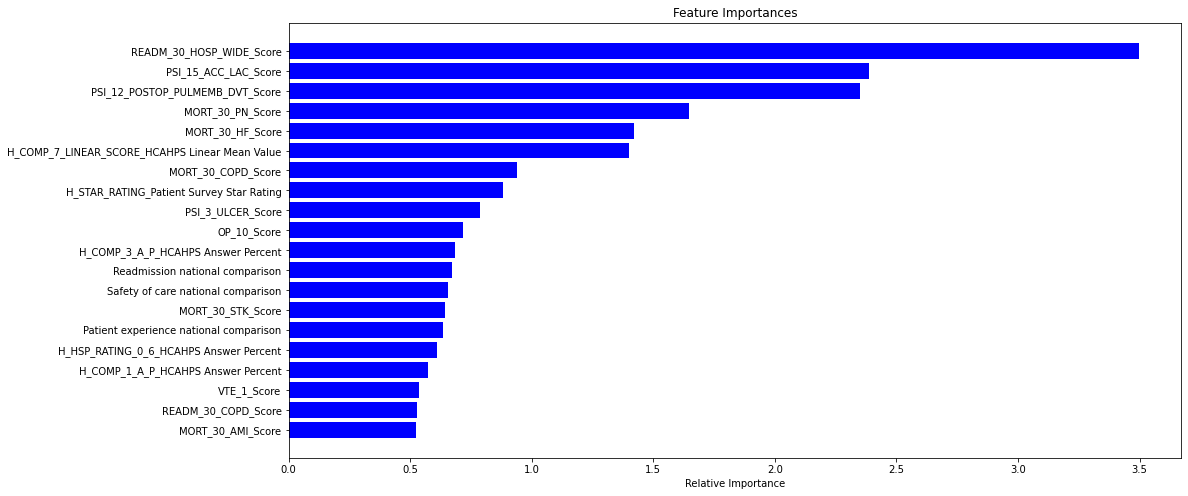

In [ ]:
# Feature Importances of logistic regression

features = X_train.columns
importances = abs(logm.coef_).mean(0)
indices = np.argsort(abs(importances))[-20:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Linear Regression (Ridge)

In [ ]:
# Instantiating Ridge Regression

rr = linear_model.Ridge(random_state=100)
rr.fit(X_train, y_train)

Ridge(random_state=100)

In [ ]:
print_scores(rr, X_train, y_train, mode='Train')


 Train Set R2: 0.88

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.93      0.90      0.91        97
         2.0       0.93      0.90      0.91       517
         3.0       0.92      0.94      0.93      1446
         4.0       0.89      0.91      0.90       768
         5.0       0.97      0.73      0.84        90

    accuracy                           0.92      2918
   macro avg       0.93      0.87      0.90      2918
weighted avg       0.92      0.92      0.92      2918



In [ ]:
print_scores(rr, X_test, y_test, mode='Test')


 Test Set R2: 0.86

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.90      0.90      0.90        20
         2.0       0.94      0.80      0.87       167
         3.0       0.87      0.94      0.91       326
         4.0       0.91      0.93      0.92       196
         5.0       1.00      0.71      0.83        21

    accuracy                           0.90       730
   macro avg       0.92      0.86      0.88       730
weighted avg       0.90      0.90      0.90       730



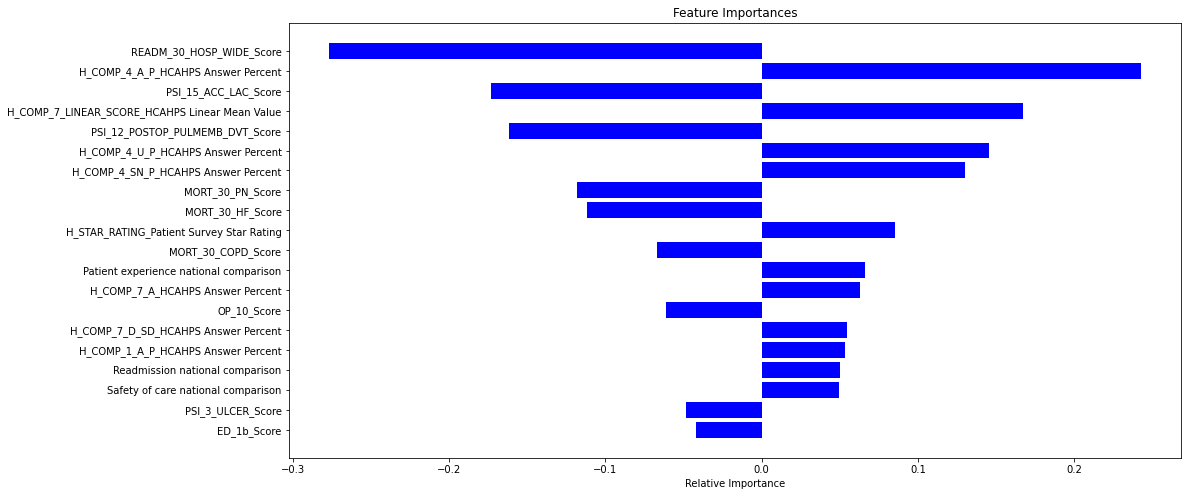

In [ ]:
# Feature Importances of Ridge Regression

features = X_train.columns
importances = rr.coef_
indices = np.argsort(abs(importances))[-20:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Gradient Boosting Classifier

In [ ]:
# Instantiating Gradient Boosting Classifier
 
gbc = XGBClassifier(multi_class = 'ovr', random_state=100)
gbc.fit(X_train, y_train)

XGBClassifier(multi_class='ovr', objective='multi:softprob', random_state=100)

In [ ]:
print_scores(gbc, X_train, y_train, mode='Train')


 Train Set R2: 0.91

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.97      0.98        97
         2.0       0.98      0.89      0.93       517
         3.0       0.91      0.98      0.94      1446
         4.0       0.95      0.90      0.92       768
         5.0       1.00      0.89      0.94        90

    accuracy                           0.94      2918
   macro avg       0.97      0.92      0.94      2918
weighted avg       0.94      0.94      0.94      2918



In [ ]:
print_scores(gbc, X_test, y_test, mode='Test')


 Test Set R2: 0.67

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.88      0.35      0.50        20
         2.0       0.76      0.62      0.68       167
         3.0       0.72      0.88      0.80       326
         4.0       0.84      0.76      0.80       196
         5.0       0.87      0.62      0.72        21

    accuracy                           0.76       730
   macro avg       0.81      0.64      0.70       730
weighted avg       0.77      0.76      0.76       730



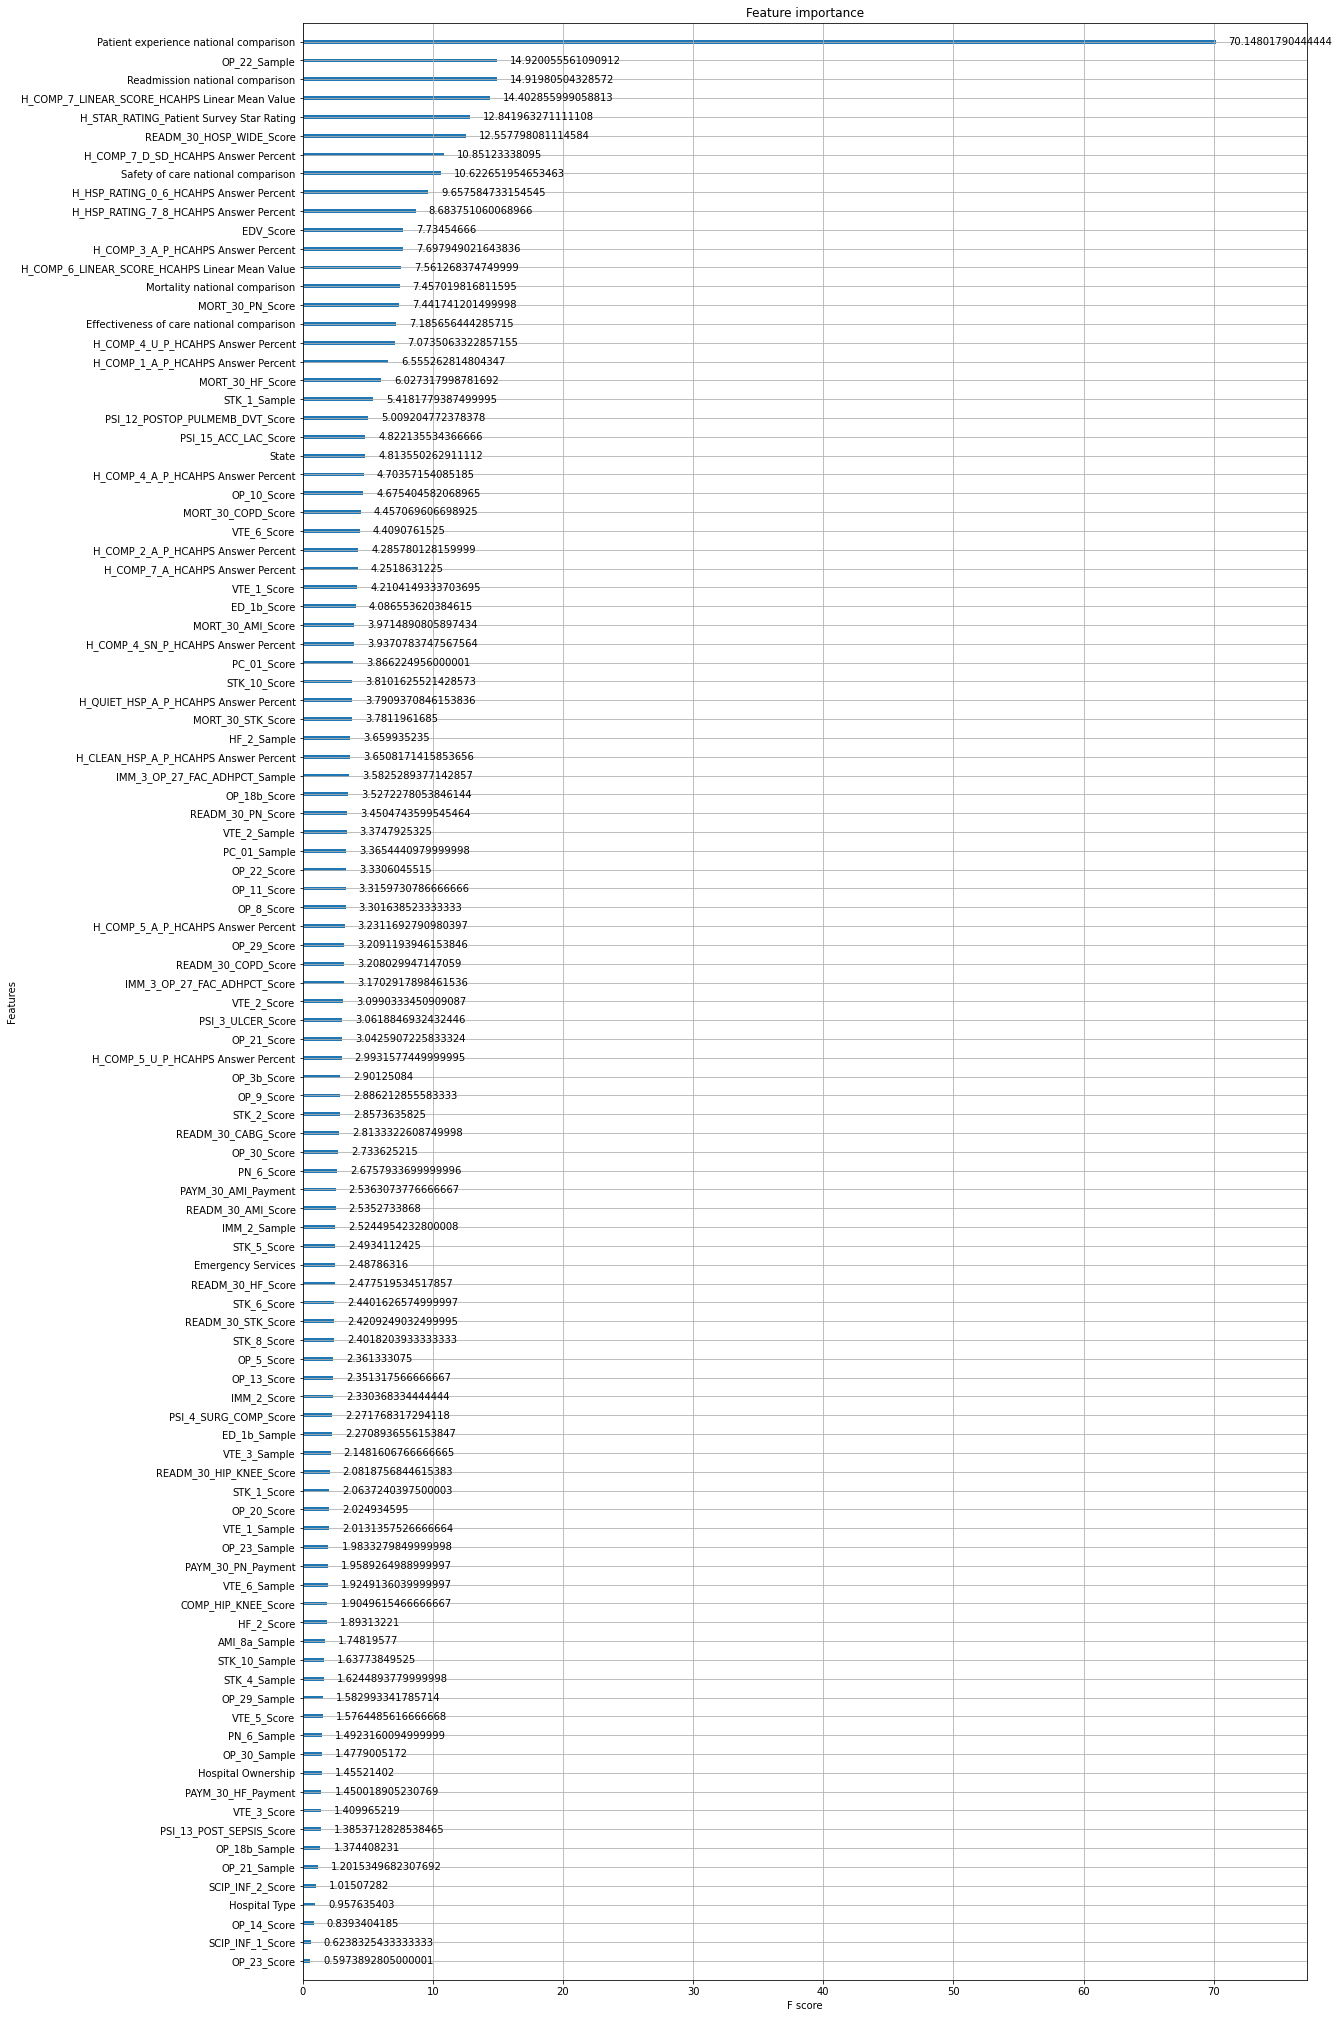

In [ ]:
# Feature Importances of Gradient Boosting Classifier

fig, ax = plt.subplots(figsize=(18,36))
plot_importance(gbc, importance_type='gain', ax=ax) #gain, cover, weight
plt.show()

# Gradient Boosting Regressor

In [ ]:
# Instantiating Gradient Boosting Regressor 

gbr = XGBRegressor(random_state=100)
gbr.fit(X_train, y_train)

[19:23:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(random_state=100)

In [ ]:
print_scores(gbr, X_train, y_train, mode='Train')


 Train Set R2: 0.9

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.96      0.90      0.93        97
         2.0       0.94      0.91      0.92       517
         3.0       0.93      0.96      0.94      1446
         4.0       0.93      0.91      0.92       768
         5.0       0.92      0.79      0.85        90

    accuracy                           0.93      2918
   macro avg       0.93      0.89      0.91      2918
weighted avg       0.93      0.93      0.93      2918



In [ ]:
print_scores(gbr, X_test, y_test, mode='Test')


 Test Set R2: 0.8

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.55      0.71        20
         2.0       0.88      0.78      0.83       167
         3.0       0.82      0.92      0.87       326
         4.0       0.88      0.86      0.87       196
         5.0       0.94      0.71      0.81        21

    accuracy                           0.85       730
   macro avg       0.90      0.76      0.82       730
weighted avg       0.86      0.85      0.85       730



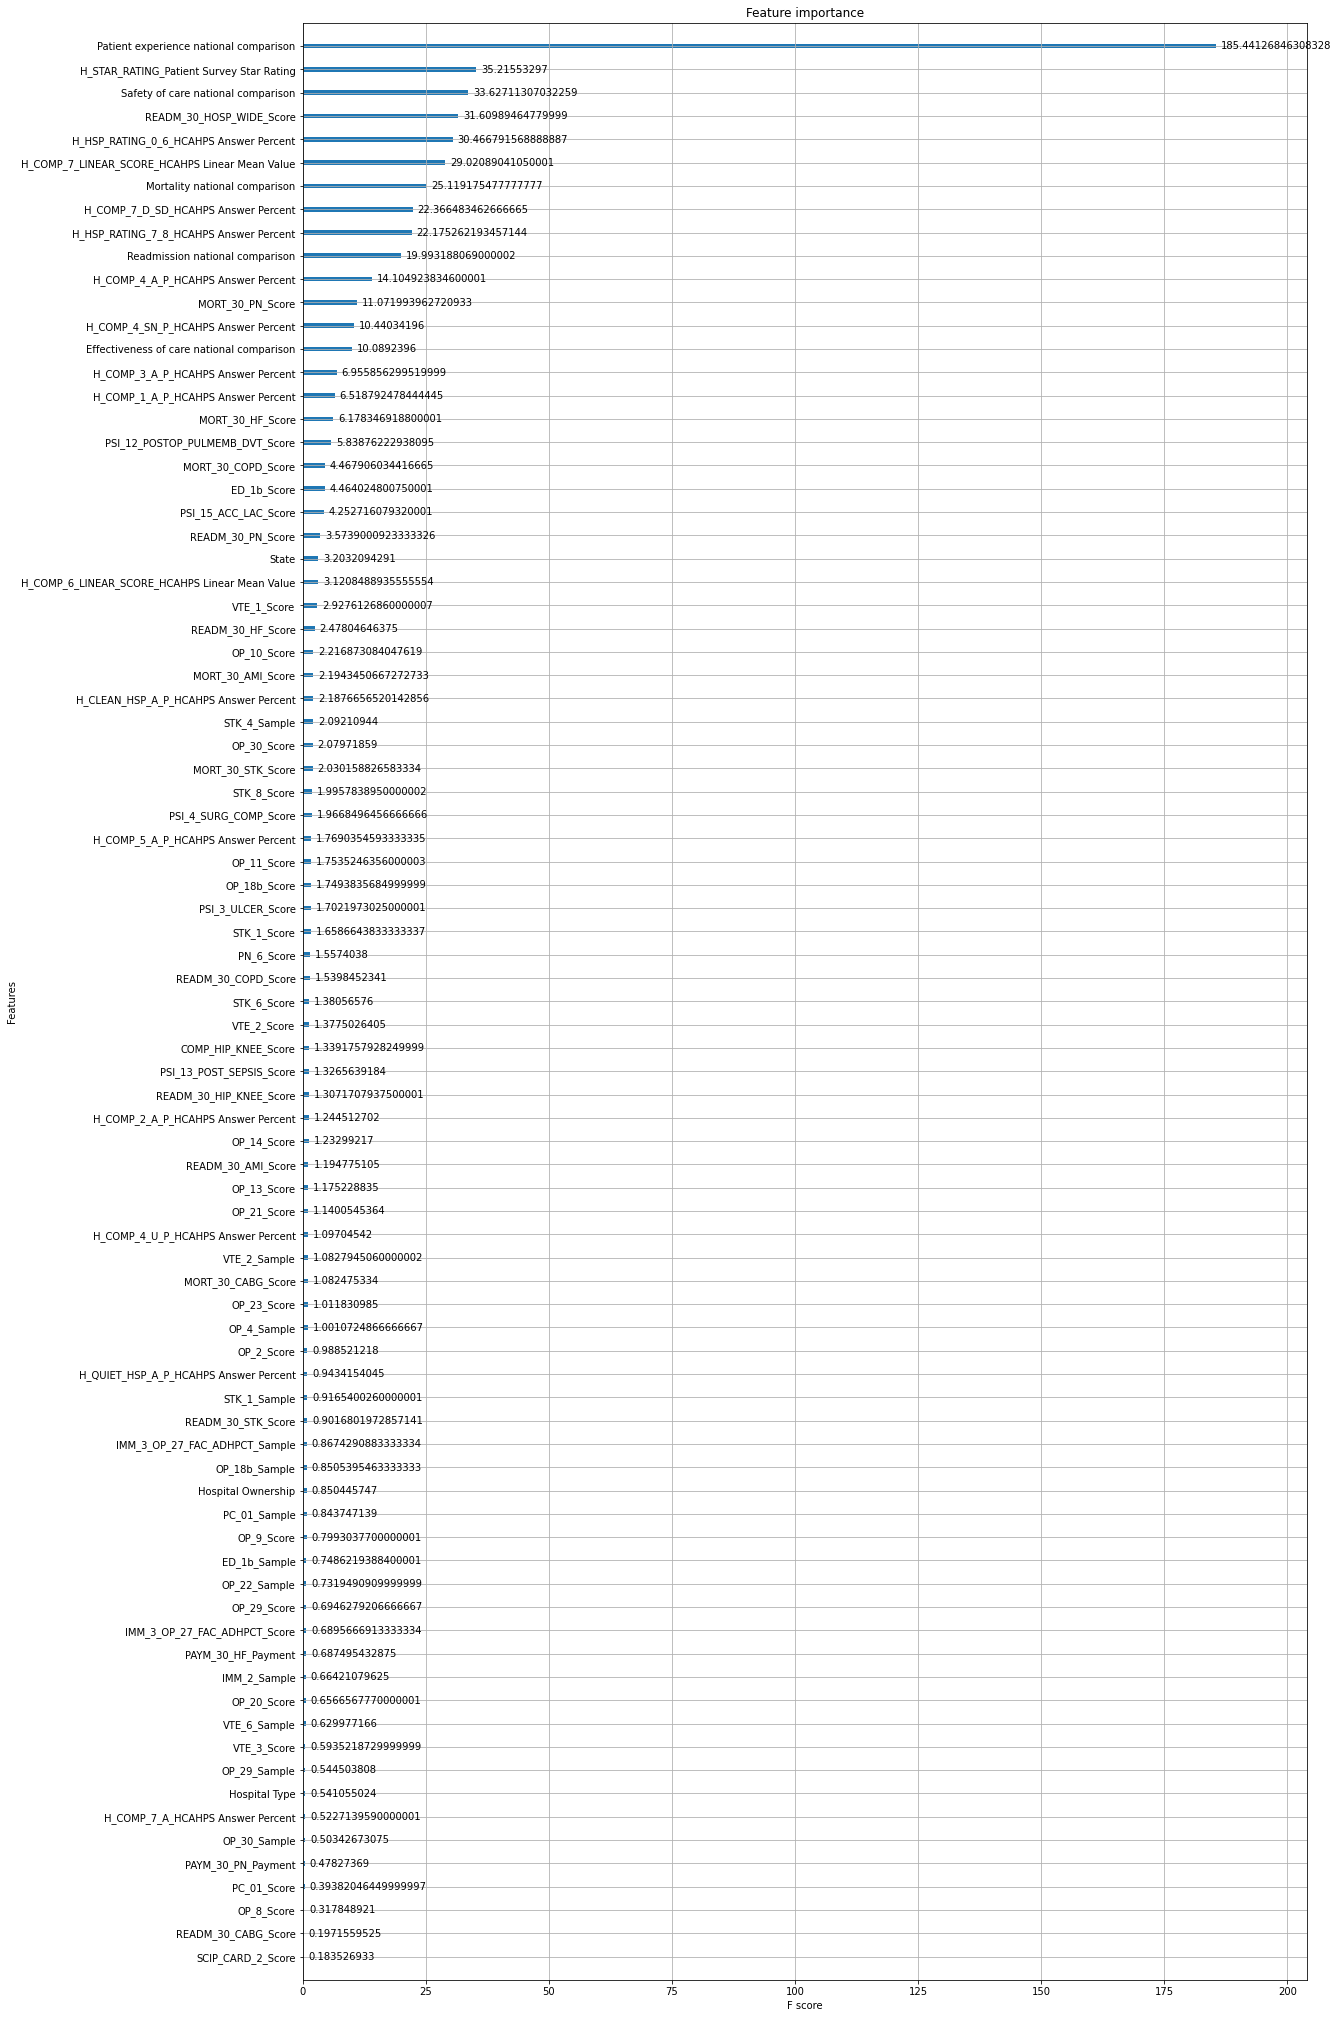

In [ ]:
# Feature Importances of Gradient Boosting Regressor

fig, ax = plt.subplots(figsize=(18,36))
plot_importance(gbr, importance_type='gain', ax=ax) #gain, cover, weight
plt.show()

# Random Forest Classifier

In [ ]:
# Instantiating Random Forest Classifier

rfc = RandomForestClassifier(random_state=100, min_samples_leaf= 3)
rfc.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=3, random_state=100)

In [ ]:
print_scores(rfc, X_train, y_train, mode='Train')


 Train Set R2: 0.97

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.88      0.93        97
         2.0       0.98      0.97      0.97       517
         3.0       0.98      1.00      0.99      1446
         4.0       0.98      0.99      0.98       768
         5.0       1.00      0.81      0.90        90

    accuracy                           0.98      2918
   macro avg       0.99      0.93      0.95      2918
weighted avg       0.98      0.98      0.98      2918



In [ ]:
print_scores(rfc, X_test, y_test, mode='Test')


 Test Set R2: 0.59

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.75      0.15      0.25        20
         2.0       0.78      0.53      0.63       167
         3.0       0.67      0.89      0.76       326
         4.0       0.76      0.64      0.70       196
         5.0       0.78      0.33      0.47        21

    accuracy                           0.71       730
   macro avg       0.75      0.51      0.56       730
weighted avg       0.72      0.71      0.69       730



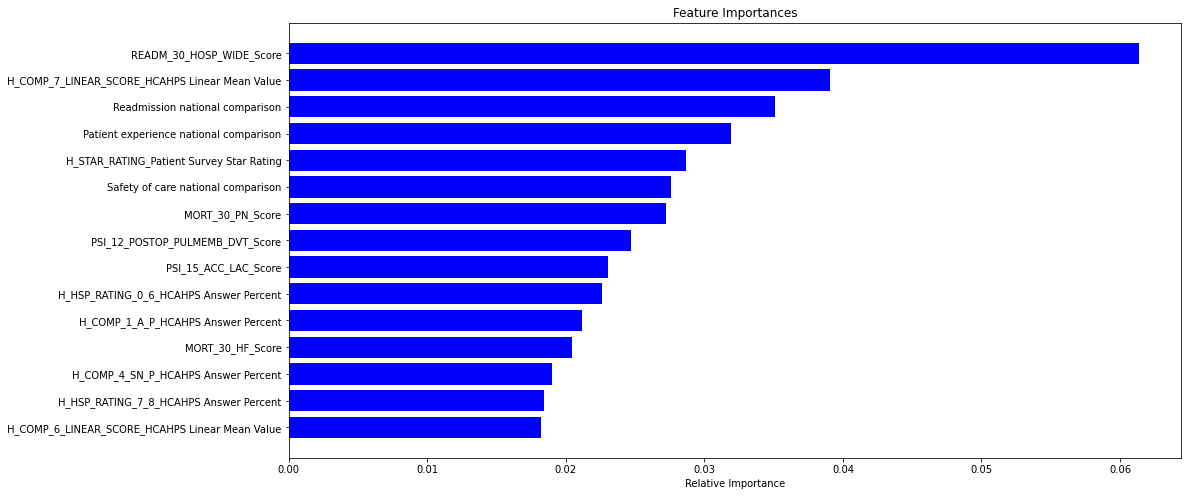

In [ ]:
# Feature Importances of Random Forest Classifier

features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Random Forest Regressor

In [ ]:
# Instantiating Random Forest Regressor

rfr = RandomForestRegressor(random_state = 100)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=100)

In [ ]:
print_scores(rfr, X_train, y_train, mode='Train')


 Train Set R2: 1.0

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.96      0.98        97
         2.0       0.99      1.00      0.99       517
         3.0       1.00      1.00      1.00      1446
         4.0       1.00      1.00      1.00       768
         5.0       1.00      0.99      0.99        90

    accuracy                           1.00      2918
   macro avg       1.00      0.99      0.99      2918
weighted avg       1.00      1.00      1.00      2918



In [ ]:
print_scores(rfr, X_test, y_test, mode='Test')


 Test Set R2: 0.69

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.40      0.57        20
         2.0       0.79      0.66      0.72       167
         3.0       0.74      0.87      0.80       326
         4.0       0.81      0.79      0.80       196
         5.0       1.00      0.57      0.73        21

    accuracy                           0.78       730
   macro avg       0.87      0.66      0.72       730
weighted avg       0.79      0.78      0.77       730



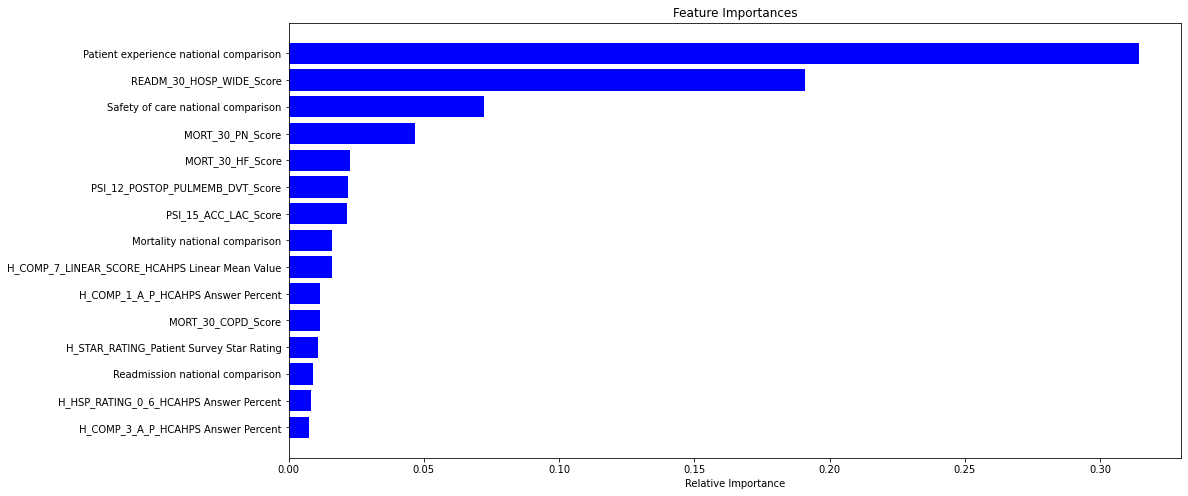

In [ ]:
# Feature Importances of Random Forest Regressor

features = X_train.columns
importances = rfr.feature_importances_
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Shallow Neural Network Models - Classifier

In [ ]:
%%time

tf.keras.backend.clear_session()
tf.random.set_seed(9713)

n_feats = X_train.shape[1]

elastic_net = tf.keras.regularizers.L1L2(l1=0.1, l2=0.1)

feature_input = tf.keras.layers.Input(shape=(n_feats,), dtype=tf.float32, sparse=False, name='feature_input')

# 3 dense layers with batch norm and drop-out regularization
net = tf.keras.layers.Dense(n_feats, activation='relu')(feature_input) #kernel_regularizer=elastic_net
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.30)(net)

net = tf.keras.layers.Dense(75, activation='relu')(net) #kernel_regularizer='l1_l2'
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.15)(net)

net = tf.keras.layers.Dense(25, activation='relu')(net) #kernel_regularizer='l1_l2'
net = tf.keras.layers.BatchNormalization()(net)
# net = tf.keras.layers.Dropout(0.25)(net)

classifier = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net)

model = tf.keras.Model(feature_input, classifier)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   [(None, 125)]             0         
_________________________________________________________________
dense (Dense)                (None, 125)               15750     
_________________________________________________________________
batch_normalization (BatchNo (None, 125)               500       
_________________________________________________________________
dropout (Dropout)            (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                9450      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)                300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0     

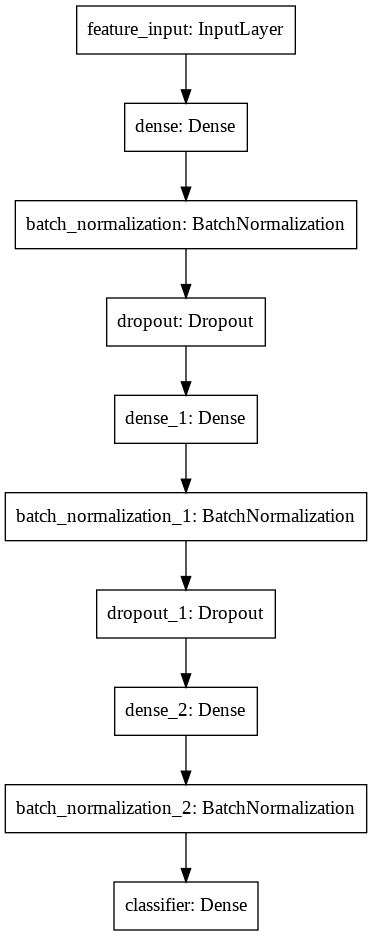

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
%%time
callback = tf.keras.callbacks.EarlyStopping(patience=3)

model.compile(
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
)

history = model.fit(X_train.values, np.array(y_train)-1, batch_size=32, epochs=25, shuffle=True, validation_split=0.2, callbacks=[callback]) #, validation_split=0.2, callbacks=[callback], validation_data=(X_test_processed.values, np.array(y_test))

# model.save('model.h5', save_format='h5')

history_df = pd.DataFrame(history.history)

Epoch 1/25
73/73 [==============================] - 1s 5ms/step - loss: 1.6536 - accuracy: 0.3560 - val_loss: 1.2970 - val_accuracy: 0.5291
Epoch 2/25
73/73 [==============================] - 0s 3ms/step - loss: 1.1060 - accuracy: 0.5784 - val_loss: 0.9943 - val_accuracy: 0.6678
Epoch 3/25
73/73 [==============================] - 0s 3ms/step - loss: 0.8454 - accuracy: 0.6924 - val_loss: 0.7673 - val_accuracy: 0.7192
Epoch 4/25
73/73 [==============================] - 0s 3ms/step - loss: 0.6765 - accuracy: 0.7528 - val_loss: 0.6325 - val_accuracy: 0.7551
Epoch 5/25
73/73 [==============================] - 0s 3ms/step - loss: 0.5778 - accuracy: 0.7734 - val_loss: 0.5432 - val_accuracy: 0.7791
Epoch 6/25
73/73 [==============================] - 0s 3ms/step - loss: 0.5050 - accuracy: 0.8051 - val_loss: 0.4853 - val_accuracy: 0.8065
Epoch 7/25
73/73 [==============================] - 0s 3ms/step - loss: 0.4843 - accuracy: 0.8025 - val_loss: 0.4601 - val_accuracy: 0.8134
Epoch 8/25
73/73 [==

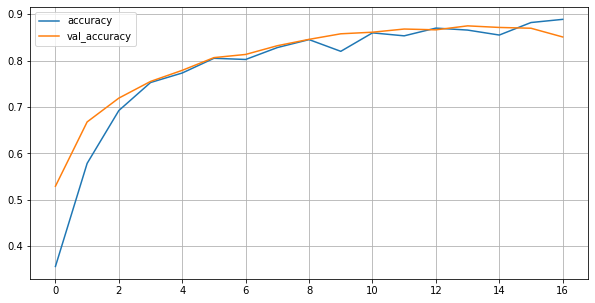

In [ ]:
history_df[['accuracy','val_accuracy']].plot(figsize=(10,5), grid=True)

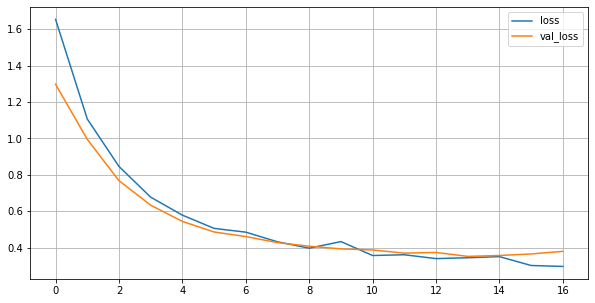

In [ ]:
history_df[['loss','val_loss']].plot(figsize=(10,5), grid=True)

In [ ]:
print_scores(model, X_train, y_train, mode='Train', tfclsf = True)


 Train Set R2: 0.93

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       1.00      0.76      0.87        97
         2.0       0.93      0.94      0.94       517
         3.0       0.96      0.96      0.96      1446
         4.0       0.95      0.95      0.95       768
         5.0       0.91      0.99      0.95        90

    accuracy                           0.95      2918
   macro avg       0.95      0.92      0.93      2918
weighted avg       0.95      0.95      0.95      2918



In [ ]:
print_scores(model, X_test, y_test, mode='Test', tfclsf = True)


 Test Set R2: 0.8

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.92      0.60      0.73        20
         2.0       0.89      0.74      0.81       167
         3.0       0.84      0.89      0.87       326
         4.0       0.86      0.89      0.88       196
         5.0       0.72      1.00      0.84        21

    accuracy                           0.85       730
   macro avg       0.85      0.83      0.82       730
weighted avg       0.86      0.85      0.85       730



# Shallow Neural Network Models - Regressor

In [ ]:
%%time

tf.keras.backend.clear_session()
tf.random.set_seed(9713)

n_feats = X_train.shape[1]

elastic_net = tf.keras.regularizers.L1L2(l1=0.1, l2=0.1)

feature_input = tf.keras.layers.Input(shape=(n_feats,), dtype=tf.float32, sparse=False, name='feature_input')

# 3 dense layers with batch norm and drop-out regularization
net = tf.keras.layers.Dense(n_feats, activation='relu')(feature_input) #kernel_regularizer=elastic_net
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.30)(net)

net = tf.keras.layers.Dense(75, activation='relu')(net) #kernel_regularizer='l1_l2'
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.15)(net)

net = tf.keras.layers.Dense(25, activation='relu')(net) #kernel_regularizer='l1_l2'
net = tf.keras.layers.BatchNormalization()(net)
# net = tf.keras.layers.Dropout(0.25)(net)

regressor = tf.keras.layers.Dense(1, name='regressor')(net)

model = tf.keras.Model(feature_input, regressor)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   [(None, 125)]             0         
_________________________________________________________________
dense (Dense)                (None, 125)               15750     
_________________________________________________________________
batch_normalization (BatchNo (None, 125)               500       
_________________________________________________________________
dropout (Dropout)            (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 75)                9450      
_________________________________________________________________
batch_normalization_1 (Batch (None, 75)                300       
_________________________________________________________________
dropout_1 (Dropout)          (None, 75)                0     

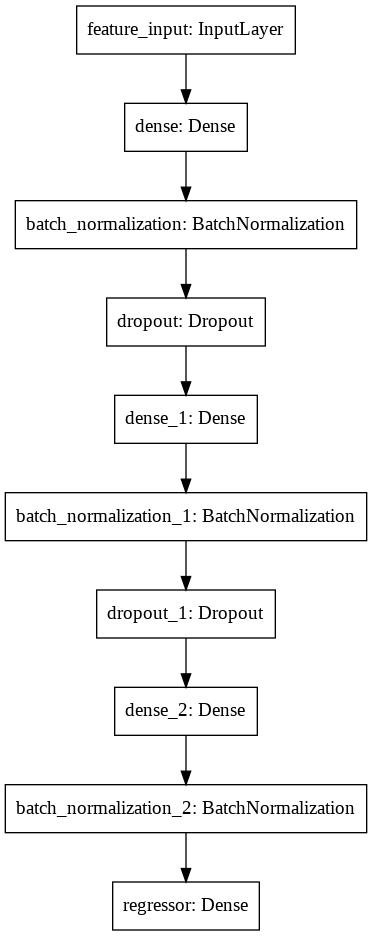

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
%%time
callback = tf.keras.callbacks.EarlyStopping(patience=3)

model.compile( 
            loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=['MeanAbsolutePercentageError']
)

history = model.fit(X_train.values, np.array(y_train), batch_size=32, epochs=25, shuffle=True, validation_split=0.2, callbacks=[callback]) #, validation_split=0.2, callbacks=[callback], validation_data=(X_test_processed.values, np.array(y_test))

# model.save('model.h5', save_format='h5')

history_df = pd.DataFrame(history.history)

Epoch 1/25
73/73 [==============================] - 1s 5ms/step - loss: 9.2561 - mean_absolute_percentage_error: 97.2104 - val_loss: 6.3980 - val_mean_absolute_percentage_error: 81.2090
Epoch 2/25
73/73 [==============================] - 0s 4ms/step - loss: 5.8212 - mean_absolute_percentage_error: 76.5477 - val_loss: 3.3770 - val_mean_absolute_percentage_error: 56.8718
Epoch 3/25
73/73 [==============================] - 0s 3ms/step - loss: 2.9888 - mean_absolute_percentage_error: 52.2933 - val_loss: 1.2250 - val_mean_absolute_percentage_error: 30.3353
Epoch 4/25
73/73 [==============================] - 0s 3ms/step - loss: 1.2814 - mean_absolute_percentage_error: 31.7678 - val_loss: 0.5988 - val_mean_absolute_percentage_error: 20.7099
Epoch 5/25
73/73 [==============================] - 0s 3ms/step - loss: 0.6935 - mean_absolute_percentage_error: 23.5829 - val_loss: 0.4109 - val_mean_absolute_percentage_error: 17.2175
Epoch 6/25
73/73 [==============================] - 0s 3ms/step - loss

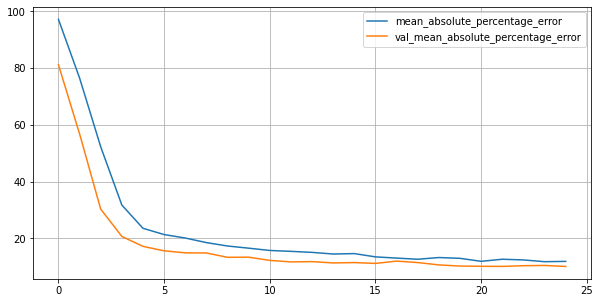

In [ ]:
history_df[['mean_absolute_percentage_error','val_mean_absolute_percentage_error']].plot(figsize=(10,5), grid=True)

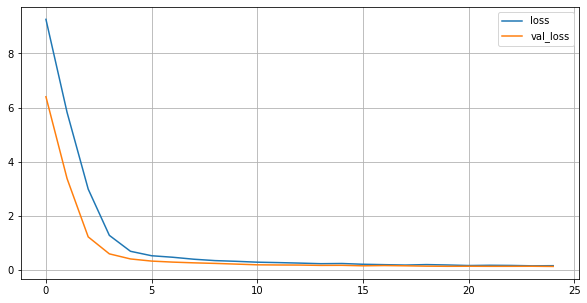

In [ ]:
history_df[['loss','val_loss']].plot(figsize=(10,5), grid=True)

In [ ]:
print_scores(model, X_train, y_train, mode='Train')


 Train Set R2: 0.86

 Train Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.94      0.76      0.84        97
         2.0       0.89      0.91      0.90       517
         3.0       0.92      0.93      0.93      1446
         4.0       0.87      0.91      0.89       768
         5.0       0.97      0.62      0.76        90

    accuracy                           0.90      2918
   macro avg       0.92      0.83      0.86      2918
weighted avg       0.91      0.90      0.90      2918



In [ ]:
print_scores(model, X_test, y_test, mode='Test')


 Test Set R2: 0.77

 Test Set Clasification Report:
               precision    recall  f1-score   support

         1.0       0.87      0.65      0.74        20
         2.0       0.87      0.78      0.83       167
         3.0       0.83      0.87      0.85       326
         4.0       0.81      0.87      0.84       196
         5.0       1.00      0.57      0.73        21

    accuracy                           0.83       730
   macro avg       0.87      0.75      0.80       730
weighted avg       0.84      0.83      0.83       730



# Shallow Neural Network Models - Classification and Regression combined 

In [ ]:
%%time

tf.keras.backend.clear_session()
tf.random.set_seed(9713)

n_feats = X_train.shape[1]

elastic_net = tf.keras.regularizers.L1L2(l1=0.1, l2=0.1)

feature_input = tf.keras.layers.Input(shape=(n_feats,), dtype=tf.float32, sparse=False, name='feature_input')

# 3 dense layers with batch norm and drop-out regularization
net = tf.keras.layers.Dense(n_feats, activation='relu')(feature_input) #kernel_regularizer=elastic_net
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.30)(net)

net = tf.keras.layers.Dense(75, activation='relu')(net) #kernel_regularizer='l1_l2'
net = tf.keras.layers.BatchNormalization()(net)
net = tf.keras.layers.Dropout(0.15)(net)

net_r = tf.keras.layers.Dense(25, activation='relu')(net) #kernel_regularizer='l1_l2'
net_r = tf.keras.layers.BatchNormalization()(net_r)
regressor = tf.keras.layers.Dense(1, name='regressor')(net_r)

net_c = tf.keras.layers.Dense(25, activation='relu')(net) #kernel_regularizer='l1_l2'
net_c = tf.keras.layers.BatchNormalization()(net_c)
classifier = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(net_c)

model = tf.keras.Model(feature_input, [classifier, regressor])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      [(None, 125)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 125)          15750       feature_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 125)          500         dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (None, 125)          0           batch_normalization[0][0]        
______________________________________________________________________________________________

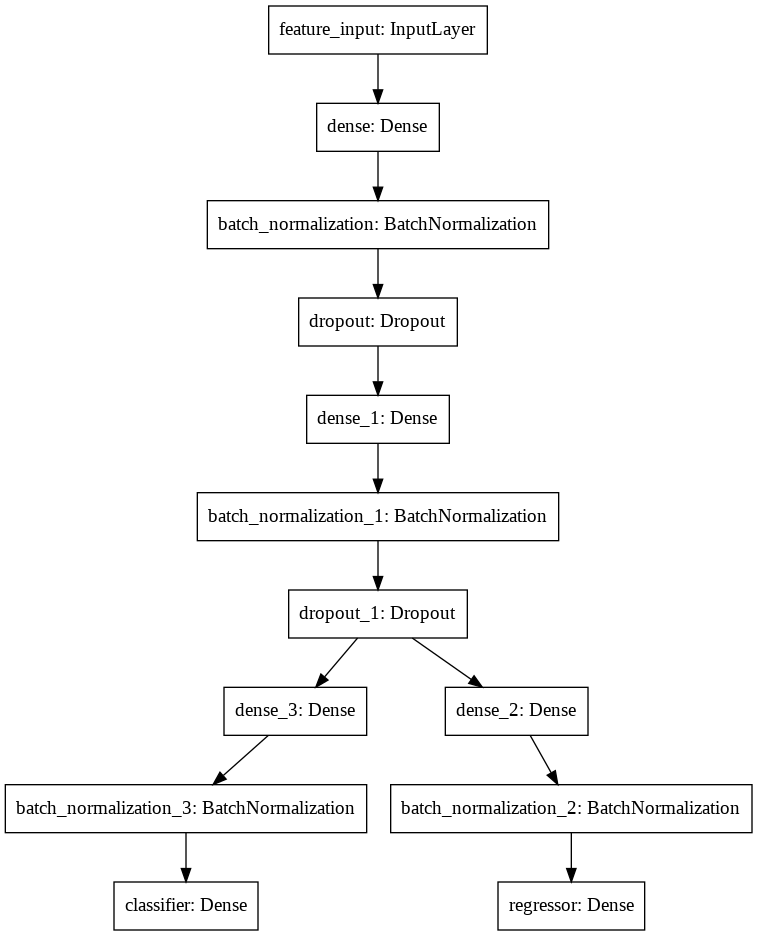

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
%%time
callback = tf.keras.callbacks.EarlyStopping(patience=5)

model.compile( 
            loss={'classifier':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'regressor':tf.keras.losses.MeanSquaredError()},
            optimizer=tf.keras.optimizers.Adam()
)

history = model.fit(X_train.values, [np.array(y_train)-1, np.array(y_train)], batch_size=32, epochs=25, shuffle=True)

# model.save('model.h5', save_format='h5')

history_df = pd.DataFrame(history.history)

Epoch 1/25
92/92 [==============================] - 2s 3ms/step - loss: 10.4755 - classifier_loss: 1.6464 - regressor_loss: 8.8291
Epoch 2/25
92/92 [==============================] - 0s 3ms/step - loss: 5.8488 - classifier_loss: 1.1709 - regressor_loss: 4.6778
Epoch 3/25
92/92 [==============================] - 0s 3ms/step - loss: 2.6765 - classifier_loss: 0.9205 - regressor_loss: 1.7559
Epoch 4/25
92/92 [==============================] - 0s 3ms/step - loss: 1.5302 - classifier_loss: 0.7629 - regressor_loss: 0.7673
Epoch 5/25
92/92 [==============================] - 0s 3ms/step - loss: 1.1587 - classifier_loss: 0.6935 - regressor_loss: 0.4651
Epoch 6/25
92/92 [==============================] - 0s 3ms/step - loss: 0.9731 - classifier_loss: 0.6095 - regressor_loss: 0.3636
Epoch 7/25
92/92 [==============================] - 0s 3ms/step - loss: 0.8841 - classifier_loss: 0.5688 - regressor_loss: 0.3153
Epoch 8/25
92/92 [==============================] - 0s 3ms/step - loss: 0.8336 - classifi

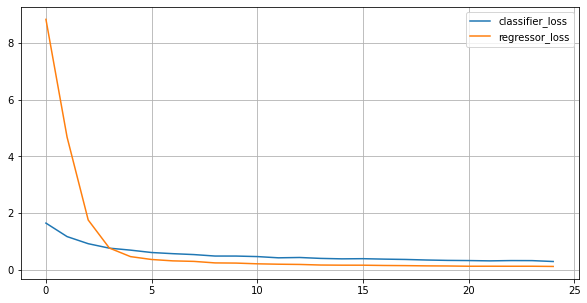

In [ ]:
history_df[['classifier_loss','regressor_loss']].plot(figsize=(10,5), grid=True)

Classifier Output

In [ ]:
y_train_pred = model.predict(X_train)[0].argmax(axis=-1)+1
print(round(r2_score(y_train, y_train_pred),2))
print(classification_report(y_train, y_train_pred))

0.96
              precision    recall  f1-score   support

         1.0       0.94      0.82      0.88        97
         2.0       0.95      0.97      0.96       517
         3.0       0.98      0.98      0.98      1446
         4.0       0.98      0.98      0.98       768
         5.0       0.97      0.94      0.96        90

    accuracy                           0.97      2918
   macro avg       0.96      0.94      0.95      2918
weighted avg       0.97      0.97      0.97      2918



In [ ]:
y_test_pred = model.predict(X_test)[0].argmax(axis=-1)+1
print(round(r2_score(y_test, y_test_pred),2))
print(classification_report(y_test, y_test_pred))

0.86
              precision    recall  f1-score   support

         1.0       0.83      0.75      0.79        20
         2.0       0.90      0.82      0.86       167
         3.0       0.87      0.94      0.90       326
         4.0       0.94      0.91      0.92       196
         5.0       1.00      0.90      0.95        21

    accuracy                           0.90       730
   macro avg       0.91      0.86      0.88       730
weighted avg       0.90      0.90      0.90       730



Regressor Output

In [ ]:
y_train_pred = model.predict(X_train)[1].round()
print(round(r2_score(y_train, y_train_pred),2))
print(classification_report(y_train, y_train_pred))

0.94
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.72      0.84        97
         2.0       0.95      0.94      0.94       517
         3.0       0.97      0.99      0.98      1446
         4.0       0.97      0.96      0.97       768
         5.0       0.90      0.86      0.88        90
         6.0       0.00      0.00      0.00         0

    accuracy                           0.96      2918
   macro avg       0.68      0.64      0.66      2918
weighted avg       0.96      0.96      0.96      2918



In [ ]:
y_test_pred = model.predict(X_test)[1].round()
print(round(r2_score(y_test, y_test_pred),2))
print(classification_report(y_test, y_test_pred))

0.83
              precision    recall  f1-score   support

         1.0       0.92      0.60      0.73        20
         2.0       0.89      0.78      0.83       167
         3.0       0.85      0.92      0.89       326
         4.0       0.90      0.91      0.91       196
         5.0       0.95      0.90      0.93        21

    accuracy                           0.88       730
   macro avg       0.90      0.82      0.86       730
weighted avg       0.88      0.88      0.88       730



### We see that Ridge Regression and combined Tensorflow (classifier output) has the best performance with respect to Accuracy as well as R2

# Fin!